This notebooks aims to build several regressor along with comparing the metrices to predict the airbnb house price.


**Reading**
- [What In The World Are QQ Plots?](https://towardsdatascience.com/what-in-the-world-are-qq-plots-20d0e41dece1)

## 0: Loading all the modules and data

In [68]:
# Data pre-processing
import numpy as np 
import pandas as pd

# Viz.
import matplotlib
import missingno
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

# Utils
import collections
import itertools
                   
# Scientific computing
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm

# ML Sklearn                   
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

# Other ML
from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs() # Load JS visualization code to notebook

# Handling warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [69]:
# Loading the data
airbnb = pd.read_csv("data/AB_NYC_2019.csv")
airbnb.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [70]:
# Shape
airbnb.shape

(48895, 16)

In [71]:
# Info
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [72]:
# Converting last_review to datetime
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'], infer_datetime_format=True)

## 1: Pre-processing and EDA

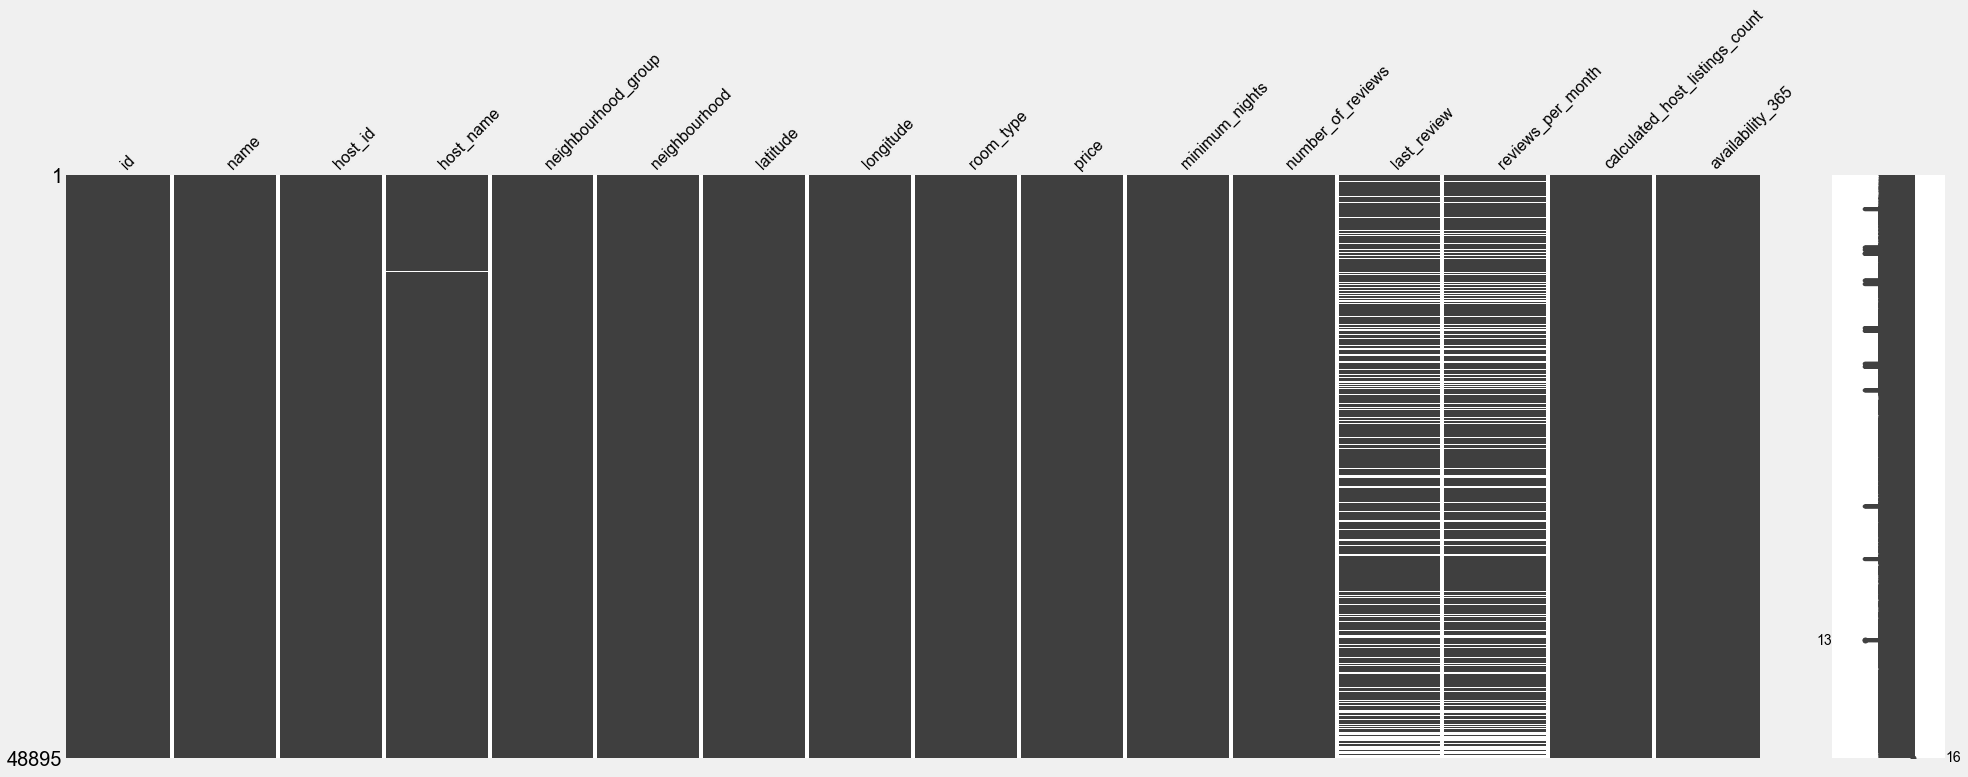

In [73]:
# Viewing all the missing values
missingno.matrix(airbnb, figsize=(30,10))

In [74]:
# Getting all the percent and count of missing values
def get_missing_count(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
    return missing_data

In [75]:
get_missing_count(airbnb)

,Total,Percent
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


In [76]:
# Information without any use
airbnb.drop(['name', 'host_name'], axis=1, inplace=True)

reviews_per_month is 0 at 10052 rows, which indicate no review. Hence, filling it with 0

In [77]:
airbnb['reviews_per_month'] = airbnb['reviews_per_month'].fillna(0)

In [78]:
# Filling last_review to remove all the empty values
earliest = min(airbnb['last_review'])
airbnb['last_review'] = airbnb['last_review'].fillna(earliest)
airbnb['last_review'] = airbnb['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal()) # Finding the number of days

In [79]:
get_missing_count(airbnb)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


Now we have no missing values

### Transforming the target variable
Target has a highly skewed distribution. This can cause problems for machine learning algorithms such as linear regression. A log transformation and removal of outliers makes the distribution look much closer to normal.

In [80]:
def visualise_skewness(column):
    fig, axes = plt.subplots(1,3, figsize=(21,4))
    sns.distplot(column, ax=axes[0])
    sns.distplot(np.log1p(column), ax=axes[1])
    axes[1].set_xlabel('log(1+price)')
    sm.qqplot(np.log1p(column), stats.norm, fit=True, line='45', ax=axes[2]);

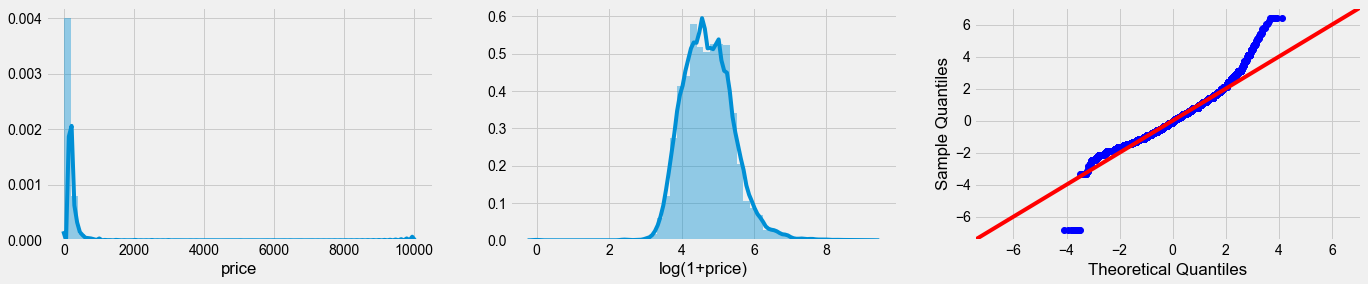

In [81]:
# Checking the distribution of the price
visualise_skewness(airbnb['price'])

Looking at the log(1+price) chart we can see that majority of prices lie in the range 3 to 8. Hence, only picking rows 3 to 8 to avoid any outliers

In [86]:
airbnb = airbnb[(np.log1p(airbnb['price']) > 3) & (np.log1p(airbnb['price']) < 8)]

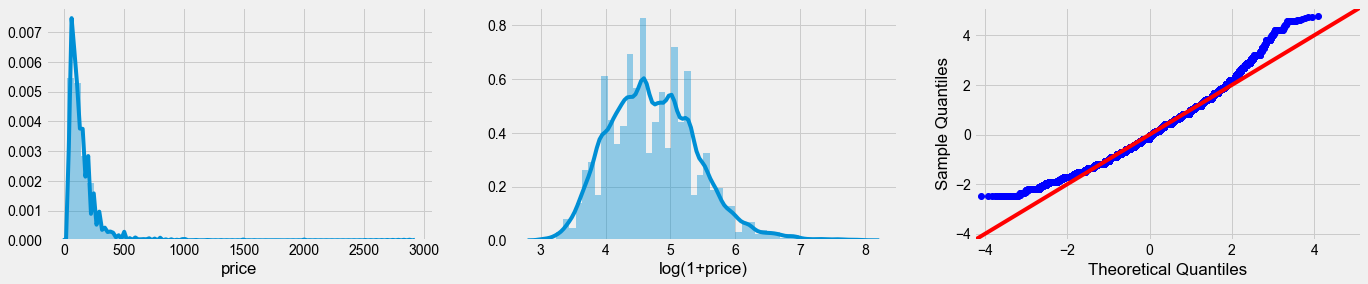

In [87]:
# Checking the distribution of the price post filtering
visualise_skewness(airbnb['price'])

In [59]:
np.log1p(149)

5.0106352940962555

In [61]:
np.log(150)

5.0106352940962555